In [25]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import random
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from scipy.stats import norm
from sklearn.preprocessing import Normalizer,StandardScaler, LabelEncoder
from tensorflow_addons.losses import pinball_loss
from sklearn.metrics import mean_pinball_loss
from scipy import stats
import math

In [26]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
horizons = [36, 48 ,60, 72, 84]

# Prepare data

In [27]:
data = pd.read_feather("data/berlin_data/historic_data/icon_eps_t_2m.feather")

data.dropna(inplace=True)
data.head()

,init_tm,met_var,location,fcst_hour,obs_tm,obs,ens_1,ens_2,ens_3,ens_4,...,ens_33,ens_34,ens_35,ens_36,ens_37,ens_38,ens_39,ens_40,ens_mean,ens_var
0,2018-12-13 00:00:00+00:00,t_2m,Berlin,0.0,2018-12-13 00:00:00+00:00,2.3,0.05,0.03,0.32,0.61,...,0.30,-0.03,0.44,0.42,0.05,0.47,0.51,0.74,0.34500,0.148036
1,2018-12-13 00:00:00+00:00,t_2m,Berlin,1.0,2018-12-13 01:00:00+00:00,2.3,0.06,0.00,0.34,0.51,...,0.13,0.05,0.39,0.38,0.04,0.38,0.33,0.60,0.30125,0.162580
2,2018-12-13 00:00:00+00:00,t_2m,Berlin,2.0,2018-12-13 02:00:00+00:00,2.2,0.10,0.11,0.40,0.45,...,0.08,0.15,0.57,0.37,0.08,0.42,0.31,0.57,0.32525,0.171626
3,2018-12-13 00:00:00+00:00,t_2m,Berlin,3.0,2018-12-13 03:00:00+00:00,2.2,0.12,0.32,0.48,0.42,...,0.05,0.19,0.68,0.32,0.08,0.28,0.35,0.60,0.31700,0.161878
4,2018-12-13 00:00:00+00:00,t_2m,Berlin,4.0,2018-12-13 04:00:00+00:00,2.1,0.11,0.57,0.54,0.35,...,0.03,0.17,0.76,0.30,0.10,0.11,0.34,0.56,0.29275,0.150544


## Calculate positional encoding for day of year

In [28]:
pos_enc = pd.DataFrame(index=pd.DatetimeIndex(data["obs_tm"]))
pos_enc["Dayofyear"] = pos_enc.index.dayofyear
pos_enc["n_days"] = 365
pos_enc.loc[pos_enc.index.year==2020,"n_days"] = 366
#Calculate actual positional encoding
cos_encoding = np.cos(2*math.pi*pos_enc["Dayofyear"]/pos_enc["n_days"])
data["pos_enc_1"] = cos_encoding.to_numpy()

## Train, val, test split

In [29]:
train_val_dataframe, test_dataframe = train_test_split(data, test_size = 0.2)#, random_state = 1)
train_dataframe, val_dataframe = train_test_split(data, test_size = 0.2)#, random_state = 2)

## Normalize and change format

In [30]:
def normalize(dataframe, label_encoder = None,feature_scaler = None, target_scaler = None, learn = False):
    #Drop unused columns
    data = dataframe.copy()
    data.drop(["init_tm", "met_var", "location", "ens_var", "obs_tm"], axis = 1, inplace = True)
    data = data.to_numpy()
    if learn == True:
        label_encoder = LabelEncoder()
        feature_scaler = StandardScaler()
        target_scaler = StandardScaler()
        #Learn label encoding for horizons
        label = label_encoder.fit_transform(data[:,0])
        #Learn target scaling
        target_scaled = target_scaler.fit_transform(data[:,1].reshape(-1,1))
        #Learn feature scaling
        features_scaled = feature_scaler.fit_transform(data[:,2:])
        #Append
        data[:,0] = label
        data[:,1] = target_scaled.reshape(-1)
        data[:,2:] = features_scaled
        
        return data, label_encoder, feature_scaler, target_scaler
    
    else:
        #Learn labels
        label = label_encoder.transform(data[:,0])
        #Scale target
        target_scaled = target_scaler.transform(data[:,1].reshape(-1,1))
        #Scale features
        features_scaled = feature_scaler.transform(data[:,2:])
        #Append
        data[:,0] = label
        data[:,1] = target_scaled.reshape(-1)
        data[:,2:] = features_scaled
        
        return data

In [31]:
train_val, label_encoder, feature_scaler, target_scaler = normalize(train_val_dataframe, learn = True)
train= normalize(train_dataframe, label_encoder, feature_scaler, target_scaler)
test = normalize(test_dataframe, label_encoder, feature_scaler, target_scaler)
val = normalize(val_dataframe, label_encoder, feature_scaler, target_scaler)
#Number of encodings
n_encodings = len(np.unique(train[:,0]))

In [32]:
def convert_format(input_data, predict = False):
    #Extract forecast embedding
    horizon_emb = input_data[:,0]
    
    if predict == False:        
        #Extract features
        features = input_data[:,2:]
        # Extract target
        target = np.expand_dims(input_data[:,1],1)
        return [features, horizon_emb], target
    else:
        #Extract features
        features = input_data[:,1:]
        return [features, horizon_emb]

In [33]:
train_data, train_target = convert_format(train)
val_data, val_target = convert_format(val)
test_data, test_target = convert_format(test)

# Build model

In [34]:
BATCH_SIZE = 512
EPOCHS = 100
learning_rate = 0.001

In [35]:
class base_model(tf.keras.Model):    
    def __init__(self, n_embeddings = n_encodings):
        super(base_model, self).__init__()
        #Embedding layers
        self.embedding = Embedding(input_dim = n_embeddings, output_dim = 4)
        #Create Dense layers
        self.hidden = Dense(64, activation = "relu")
        self.hidden2 = Dense(32, activation = "relu")
        self.out = Dense(5, activation = "linear")
        #Create Dropout
        self.dropout = Dropout(rate = 0.1)

    def call(self, input_data):
        #Extract data
        features, horizon_emb = input_data
        #Calculate embedding
        emb = self.embedding(horizon_emb)
        emb = tf.squeeze(emb, axis = 1)
        conc = Concatenate(axis = 1)([features, emb])
        #Calculate output
        output = self.hidden(conc)
        output = self.hidden2(output)
        output = self.dropout(output)
        output = self.out(output)

        return output

In [36]:
def train_model(train_data, train_target, validation_data, batch_size, epochs, learning_rate, fine_tuning = True):
    model = base_model()    
    #Define optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    #Callbacks
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 7, min_delta = 1e-5)
    model.compile(optimizer = optimizer, loss = lambda true,pred: pinball_loss(true, pred, tau = quantiles))
    #Normal fit
    history1 = model.fit(x = train_data, y = train_target, validation_data = validation_data, epochs = epochs, batch_size = BATCH_SIZE, callbacks = [callback], shuffle = True, verbose = False)
    
    #Fine tuning
    if fine_tuning == True:
        enc_horizons = label_encoder.transform(horizons)
        train_filtering = np.isin(train_data[1], enc_horizons)
        train_data_fine = [train_data[0][train_filtering], train_data[1][train_filtering]]
        train_target_fine = train_target[train_filtering]
        #Val filtering
        val_data, val_target = validation_data
        val_filtering = np.isin(val_data[1], enc_horizons)
        val_data_fine = [val_data[0][val_filtering], val_data[1][val_filtering]]
        val_target_fine = val_target[val_filtering]
        validation_data_fine = (val_data_fine, val_target_fine)
        
        #New optimizer
        history2 = model.fit(x = train_data_fine, y = train_target_fine, validation_data = validation_data_fine, epochs = epochs, batch_size = 256, callbacks = [callback], shuffle = True, verbose = False)
    return model, [history1, history2]

In [37]:
def aggregate_training(train_data, train_target, validation_data, test_data,  BATCH_SIZE, EPOCHS, learning_rate, n = 10):
    predictions = np.zeros(shape = (len(test_data[0]),5))
    for i in range(n):
        model,_ = train_model(train_data, train_target, validation_data, BATCH_SIZE, EPOCHS, learning_rate)
        pred = model.predict(test_data)
        predictions += pred
        print("Finished Training {}".format(i+1))
    predictions = predictions/n
    return predictions

In [38]:
predictions = aggregate_training(train_data, train_target, (val_data,val_target), test_data, BATCH_SIZE, EPOCHS, learning_rate, n = 10)

Finished Training 1
Finished Training 2
Finished Training 3
Finished Training 4
Finished Training 5
Finished Training 6
Finished Training 7
Finished Training 8
Finished Training 9
Finished Training 10


## Pinball Loss

### All horizons

In [43]:
total_loss = 0
for cnt,quantile in enumerate(quantiles):
    loss = mean_pinball_loss(test_target.reshape(-1), predictions[:,cnt].reshape(-1), alpha = quantile)
    total_loss += loss
    print("Pinball loss for quantile {} : \t {}".format(quantile,loss))
print("Pinball Loss total: {}".format(total_loss/len(quantiles)))

Pinball loss for quantile 0.025 : 	 0.010613077124709028
Pinball loss for quantile 0.25 : 	 0.04979077732582226
Pinball loss for quantile 0.5 : 	 0.059362761028091314
Pinball loss for quantile 0.75 : 	 0.04664098520896994
Pinball loss for quantile 0.975 : 	 0.009868831440982587
Pinball Loss total: 0.03525528642571503


### Specific horizons

In [44]:
eval_df = test_dataframe[["fcst_hour","obs"]].copy()
eval_df["obs"] = target_scaler.transform(eval_df["obs"].to_numpy().reshape(-1,1))
for cnt,quantile in enumerate(quantiles):
    eval_df[quantile] = predictions[:,cnt]
eval_df = eval_df[eval_df["fcst_hour"].isin(horizons)]

total_loss = 0
for cnt,quantile in enumerate(quantiles):
    loss = mean_pinball_loss(eval_df["obs"], eval_df[quantile], alpha = quantile)
    total_loss += loss
    print("Pinball loss for quantile {} : \t {}".format(quantile,loss))
print("Pinball Loss total: {}".format(total_loss/len(quantiles)))

Pinball loss for quantile 0.025 : 	 0.011158442293977174
Pinball loss for quantile 0.25 : 	 0.05403308639824103
Pinball loss for quantile 0.5 : 	 0.06538156653670474
Pinball loss for quantile 0.75 : 	 0.05081061924982034
Pinball loss for quantile 0.975 : 	 0.010306921298868002
Pinball Loss total: 0.038338127155522254


## Plausability

### All horizons

In [45]:
for cnt,quantile in enumerate(quantiles):
    q_smaller = (predictions[:,cnt] > test_target.flatten()).sum()
    emp_quant = q_smaller / predictions[:,cnt].size
    print("Quantile met for quantile = {}: \t {} %".format(quantile, np.round(emp_quant,4)*100))

Quantile met for quantile = 0.025: 	 1.15 %
Quantile met for quantile = 0.25: 	 19.580000000000002 %
Quantile met for quantile = 0.5: 	 47.58 %
Quantile met for quantile = 0.75: 	 79.86999999999999 %
Quantile met for quantile = 0.975: 	 99.1 %


### Specific horizons

In [46]:
for quantile in quantiles:
    q_smaller = (eval_df[quantile] > eval_df["obs"]).sum()
    emp_quant = q_smaller / eval_df[quantile].size
    print("Quantile met for quantile = {}: \t {} %".format(quantile, np.round(emp_quant,4)*100))

Quantile met for quantile = 0.025: 	 1.22 %
Quantile met for quantile = 0.25: 	 22.0 %
Quantile met for quantile = 0.5: 	 49.19 %
Quantile met for quantile = 0.75: 	 78.92 %
Quantile met for quantile = 0.975: 	 99.29 %


### Analyze crossing of quantiles

In [47]:
#Group prediction
perc_wrong_total = np.sum(np.diff(predictions) < 0) / len(predictions) * 100

#Single prediction
model,_ = train_model(train_data, train_target, (val_data, val_target), BATCH_SIZE, EPOCHS, learning_rate)
predictions_single = model.predict(test_data)
#Get amount of wrongly specified quantiles
perc_wrong_single = np.sum(np.diff(predictions_single) < 0) / len(predictions_single) * 100

print("Amount of wrongly specified quantiles in single prediction: {:.4f}%\nAmount of wrongly specified quantiles in aggregated prediction: {}%".format(perc_wrong_single, perc_wrong_total))

Amount of wrongly specified quantiles in single prediction: 0.0542%
Amount of wrongly specified quantiles in aggregated prediction: 0.0%


## Visualize predictions

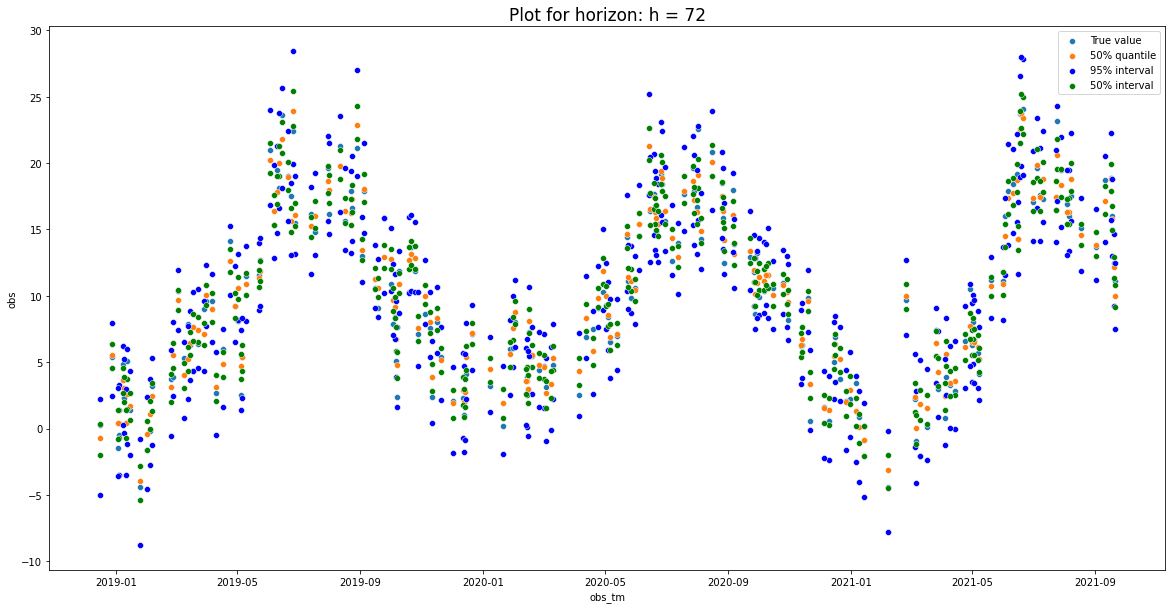

In [24]:
# Create plotting dataframe
data_plot = test_dataframe[["obs_tm","obs","fcst_hour"]].copy()
for cnt, quantile in enumerate(quantiles):
    data_plot["q{}".format(quantile)] = target_scaler.inverse_transform(predictions[:,cnt].reshape(-1,1)).reshape(-1)

#Extract horizon
h=72
data_plot = data_plot[data_plot["fcst_hour"]==h]

fig, axs = plt.subplots(figsize = (20,10))
sns.scatterplot(x = "obs_tm", y = "obs", data = data_plot, label = "True value")
sns.scatterplot(x = "obs_tm", y = "q0.5", data = data_plot, label = "50% quantile")
sns.scatterplot(x = "obs_tm", y = "q0.025", data = data_plot, color = "blue", label = "95% interval")
sns.scatterplot(x = "obs_tm", y = "q0.975", data = data_plot, color = "blue")

sns.scatterplot(x = "obs_tm", y = "q0.25", data = data_plot, color = "green", label = "50% interval")
sns.scatterplot(x = "obs_tm", y = "q0.75", data = data_plot, color = "green")
axs.set_title("Plot for horizon: h = {}".format(h),size = 17)
axs.legend()

# Predict new data

## Train on complete data

In [24]:
train_data, train_target = convert_format(train_val)
val_data, val_target = convert_format(test)

## Predict new data

In [26]:
current_date = date.today().strftime("%Y%m%d")
path = "data/berlin_data/icon_data/icon-eu-eps_{}00_t_2m_Berlin.txt".format(current_date)
new_data = pd.read_csv(path.format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data.columns = new_data.columns.str.replace(" ", "")
new_data = new_data[new_data["fcst_hour"].isin(horizons)]
#Create positional encoding
date_list = [(date.today()+timedelta(x)) for x in horizons]
new_data["day"] = pd.DatetimeIndex(date_list).dayofyear
new_data["pos_enc_1"] = np.sin(2*math.pi*new_data["day"]/365)
new_data["pos_enc_2"] = np.cos(2*math.pi*new_data["day"]/365)
new_data.drop("day", axis = 1, inplace = True)
# Normalize and get horizons
new_data = new_data[new_data["fcst_hour"].isin(horizons)].to_numpy()
new_data[:,1:] = feature_scaler.transform(new_data[:,1:])
new_data[:,0] = label_encoder.transform(new_data[:,0])

In [27]:
pred_data = convert_format(new_data, predict = True)

In [28]:
#Prepare dataframe
final_prediction = pd.DataFrame(columns = ["forecast_date","target","horizon","q0.025","q0.25","q0.5","q0.75","q0.975"], index = np.arange(0,5))
final_prediction["forecast_date"] = datetime.today().strftime("%Y-%m-%d")
final_prediction["horizon"] = ["{} hour".format(x) for x in horizons]
final_prediction["target"] = "temperature"

In [29]:
# Predict data
predictions = aggregate_training(train_data, train_target, (val_data,val_target), pred_data, BATCH_SIZE, EPOCHS, learning_rate)

In [ ]:
for cnt, quantile in enumerate(quantiles):
    #Retransform predictions
    final_pred = target_scaler.inverse_transform(predictions[:,cnt].reshape(-1,1))
    final_prediction.loc[:,"q{}".format(quantile)] = final_pred

In [30]:
final_prediction

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2021-12-22,temperature,36 hour,-3.266139,-0.576967,0.522983,1.522225,3.171143
1,2021-12-22,temperature,48 hour,-2.623967,0.667200,1.345534,2.358640,4.067821
2,2021-12-22,temperature,60 hour,-1.832837,2.664071,3.339573,5.585933,6.925385
3,2021-12-22,temperature,72 hour,-4.376172,-0.202460,0.640282,2.834351,5.637070
4,2021-12-22,temperature,84 hour,-4.931462,-1.217430,0.263290,2.048362,5.066379


In [31]:
new_data = pd.read_csv(path.format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data.columns = new_data.columns.str.replace(" ", "")
new_data[new_data["fcst_hour"].isin(horizons)].quantile(0.5, axis = 1)

36   -0.36
48    0.83
52    3.47
56    0.18
58   -0.34
Name: 0.5, dtype: float64

In [32]:
final_prediction.to_pickle("../evaluation/predictions/single/{}_{}".format("temperature", date.today().strftime("%Y-%m-%d")))

# Old code

## Check relationship with time

KeyError: 0

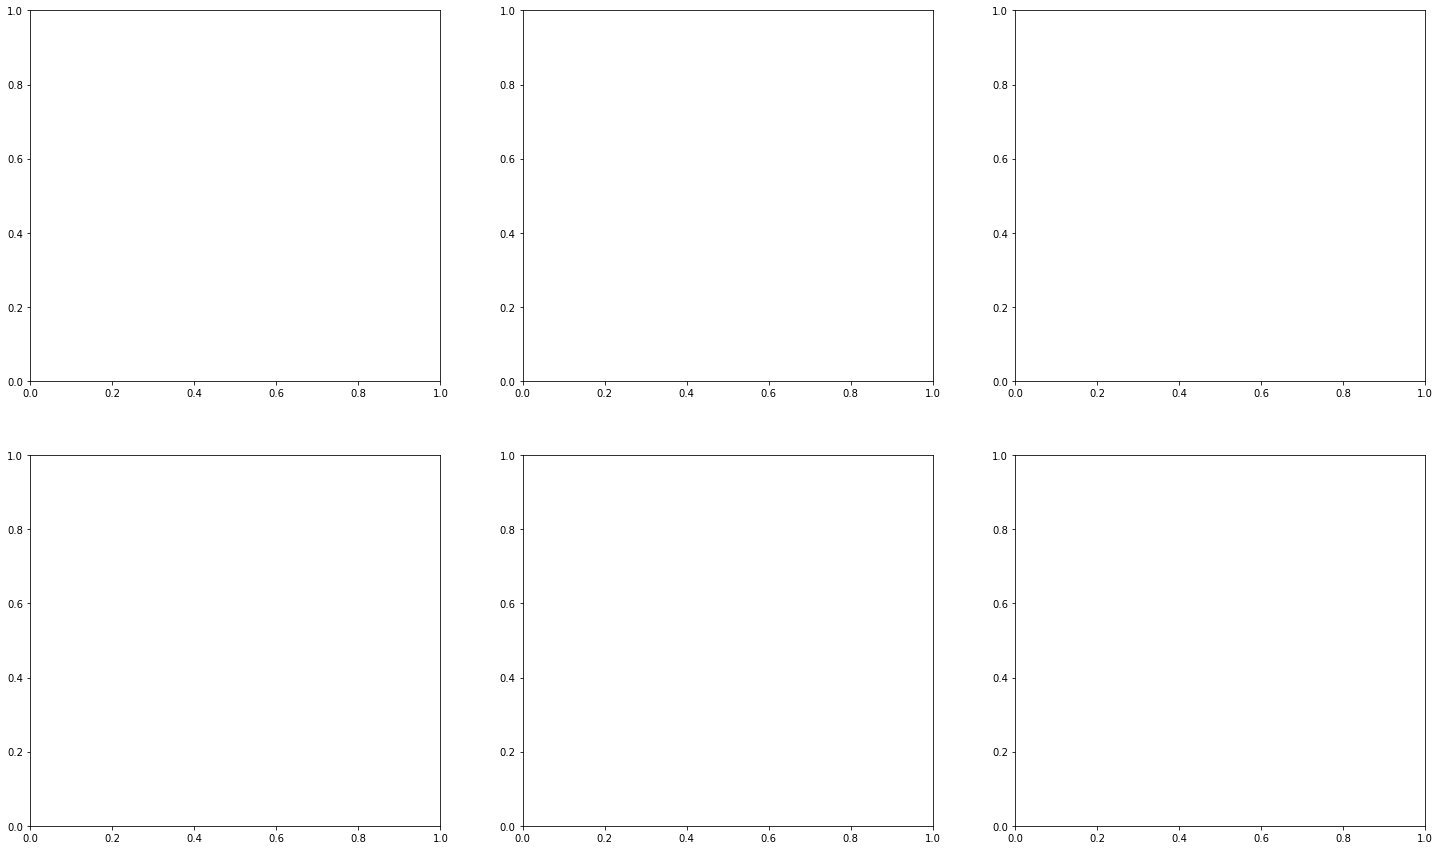

In [33]:
fig, ax = plt.subplots(2,3,figsize=(25,15))
ax = ax.ravel()
for cnt, quantile in enumerate(quantiles):
    #Renormalize and calculate forecast error
    error = mean_pinball_loss(test_dataframe["obs"].to_numpy().reshape(1,-1), target_scaler.inverse_transform(predictions[cnt]).reshape(1,-1), multioutput="raw_values", alpha=quantile)
    test_dataframe["Forecast_error"] = error
    test_dataframe["day"] = pd.DatetimeIndex(test_dataframe["obs_tm"]).dayofyear
    plot = test_dataframe.groupby("day").mean().reset_index()

    sns.regplot(x = "day", y = "Forecast_error", data=plot, ax = ax[cnt])
    ax[cnt].set_xlabel("Day of year",size = 15)
    ax[cnt].set_ylabel("Forecast error", size = 17)
    ax[cnt].set_title("Correlation for q = {}".format(quantile),size = 20)
    r = stats.pearsonr(plot["day"], plot["Forecast_error"])[0]
    rho = stats.spearmanr(plot["day"], plot["Forecast_error"])[0]
    ax[cnt].annotate('Correlation:\nr = {:.4f}\n'.format(r)+r'$\rho$ = {:.4f}'.format(rho),xy = (.01,.02), xycoords=ax[cnt].transAxes, size = 15)
    
plt.savefig("temp_time_correlation_plot.pdf", dpi=300)